# 6. 영화리뷰 텍스트 감성분석하기

In [1]:
! pip install gensim==3.8.3 nb_black

In [2]:
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

## 데이터 준비
네이버 영화 포털에 등록된 댓글들을 모아 구성된 데이터셋을 준비합니다.

In [3]:
import pandas as pd

train_data = pd.read_table("~/aiffel/sentiment_classification/data/ratings_train.txt")
test_data = pd.read_table("~/aiffel/sentiment_classification/data/ratings_test.txt")

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


<IPython.core.display.Javascript object>

데이터셋은 데이터 구분을 위한 `id`와 텍스트가 담겨 있는 `document`, 그리고 `label`로 구성되어 있습니다.

텍스트의 토큰화를 위해 한국어 형태소 분석을 도와주는 Mecab을 사용합니다.  
표준어가 아니거나 분석에 도움이 되지 않는다고 판단되는 단어들을 제외하고 훈련 데이터를 구성합니다.

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter


tokenizer = Mecab()
stopwords = [
    "의",
    "가",
    "이",
    "은",
    "들",
    "는",
    "좀",
    "잘",
    "걍",
    "과",
    "도",
    "를",
    "으로",
    "자",
    "에",
    "와",
    "한",
    "하다",
]


def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=["document"], inplace=True)
    train_data = train_data.dropna(how="any")
    test_data.drop_duplicates(subset=["document"], inplace=True)
    test_data = test_data.dropna(how="any")

    x_train = []
    for sentence in train_data["document"]:
        temp_X = tokenizer.morphs(sentence)  
        temp_X = [word for word in temp_X if not word in stopwords]
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data["document"]:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords]
        x_test.append(temp_X)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    vocab = ["", "", "", ""] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [
            word_to_index[word] if word in word_to_index else word_to_index[""]
            for word in wordlist
        ]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return (
        x_train,
        np.array(list(train_data["label"])),
        x_test,
        np.array(list(test_data["label"])),
        word_to_index,
    )

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

<IPython.core.display.Javascript object>

In [5]:
print(x_train[0])
print(y_train[0])
print(x_train[1])
print(y_train[1])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
0
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
1


<IPython.core.display.Javascript object>

In [6]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

index_to_word = {index: word for word, index in word_to_index.items()}

<IPython.core.display.Javascript object>

모든 문장은 `<BOS>`로 시작하도록 만들며, word_to_index에 포함되어 있지 않다면 알 수 없는 단어 `<UNK>`로 대체합니다.

In [7]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index["<BOS>"]] + [
        word_to_index[word] if word in word_to_index else word_to_index["<UNK>"]
        for word in sentence.split()
    ]


def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


def get_decoded_sentence(encoded_sentence, index_to_word):
    return " ".join(
        index_to_word[index] if index in index_to_word else "<UNK>"
        for index in encoded_sentence[1:]
    ) 


def get_decoded_sentences(encoded_sentences, index_to_word):
    return [
        get_decoded_sentence(encoded_sentence, index_to_word)
        for encoded_sentence in encoded_sentences
    ]

<IPython.core.display.Javascript object>

문장의 최대 길이를 정하기 위해 평균과 표준편차를 사용합니다.  
평균에서 표준편차의 두 배가 더해진 길이를 기준으로 합니다.

In [8]:
total_data_text = list(x_train) + list(x_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print("문장길이 평균 : ", np.mean(num_tokens))
print("문장길이 최대 : ", np.max(num_tokens))
print("문장길이 표준편차 : ", np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
maxlen_ratio = np.sum(num_tokens < max_tokens) / len(num_tokens) * 100
print("pad_sequences maxlen : ", maxlen)
print(
    f"전체 문장의 {maxlen_ratio:.3f}%가 maxlen 설정값 이내에 포함됩니다."
)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.430%가 maxlen 설정값 이내에 포함됩니다.


<IPython.core.display.Javascript object>

앞서 구한 문장의 최대 길이를 `pad_sequences`에 적용하여 패딩을 진행합니다.

In [9]:
import tensorflow as tf


x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, value=word_to_index["<PAD>"], maxlen=maxlen
)

x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test, value=word_to_index["<PAD>"], maxlen=maxlen
)

print(x_train.shape)

(146182, 41)


<IPython.core.display.Javascript object>

## 모델 설계

훈련 가능한 파라미터의 수가 비슷한 모델 3개를 설계합니다.

1. LSTM 레이어 1개와 2개의 FC레이어로 구성된 네트워크(LSTM)
2. 1개의 Global Max Pooling 레이어와 2개의 FC레이어로 구성된 네트워크(GMP)
3. 2개의 1D Convolution 레이어와 2개의 FC레이어로 구성된 네트워크(1D-CNN)  

이후에는 편의를 위해 각 모델에 대해 괄호 내부의 명칭을 사용하겠습니다.

In [10]:
vocab_size = 10000    
word_vector_dim = 16  

embed_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))


def my_lstm(embed_layer):
    model = tf.keras.Sequential()
    model.add(embed_layer)
    model.add(tf.keras.layers.LSTM(8))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model


model = my_lstm(embed_layer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 10)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 160,901
Trainable params: 160,901
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [11]:
def my_gmp(embed_layer):
    model = tf.keras.Sequential()
    model.add(embed_layer)
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model


model = my_gmp(embed_layer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 160,181
Trainable params: 160,181
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [12]:
def my_cnn(embed_layer):
    model = tf.keras.Sequential()
    model.add(embed_layer)
    model.add(tf.keras.layers.Conv1D(16, 7, activation="relu"))
    model.add(tf.keras.layers.MaxPooling1D(5))
    model.add(tf.keras.layers.Conv1D(16, 7, activation="relu"))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(10, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    return model


model = my_cnn(embed_layer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

<IPython.core.display.Javascript object>

검증을 위해 훈련용 데이터에서 10000개의 데이터를 분리합니다.

In [13]:
n_valid = 10000
x_val = x_train[:n_valid]
y_val = y_train[:n_valid]

partial_x_train = x_train[n_valid:]
partial_y_train = y_train[n_valid:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(136182, 41)
(136182,)
(10000, 41)
(10000,)


<IPython.core.display.Javascript object>

### 훈련 준비
총 20 epoch동안 훈련을 진행하며, 과적합이 관측되면 훈련 진행을 막기 위해 `keras`의 `EarlyStopping`을 사용합니다.  
전체 epoch의 20% 동안 validation loss의 개선이 없다면 훈련을 중단하도록 설정합니다.

In [14]:
from tensorflow.keras.callbacks import EarlyStopping


epochs = 20
stopper = EarlyStopping(monitor="val_loss", patience=epochs // 5)


def train_m(model):
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(
        partial_x_train,
        partial_y_train,
        epochs=epochs,
        batch_size=512,
        validation_data=(x_val, y_val),
        callbacks=[stopper],
        verbose=0,
    )
    return history

<IPython.core.display.Javascript object>

훈련 데이터에 대한 loss와 검증 데이터에 대한 loss 그리고 각각의 데이터에 대한 정확도를 그래프로 표현하는 함수를 선언합니다.

In [15]:
import matplotlib.pyplot as plt


def plot_history(history):
    history_dict = history.history
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, "orange", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, "orange", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## 훈련 진행
설계된 3개의 모델에 대한 훈련을 진행하며 각 모델의 validation accuracy를 저장합니다

In [16]:
result_list = []

<IPython.core.display.Javascript object>

In [17]:
model = my_lstm(embed_layer)
history = train_m(model)
results = model.evaluate(x_test, y_test, verbose=2)
# print(results)
result_list.append([model, results[1]])

1537/1537 - 3s - loss: 0.3624 - accuracy: 0.8500


<IPython.core.display.Javascript object>

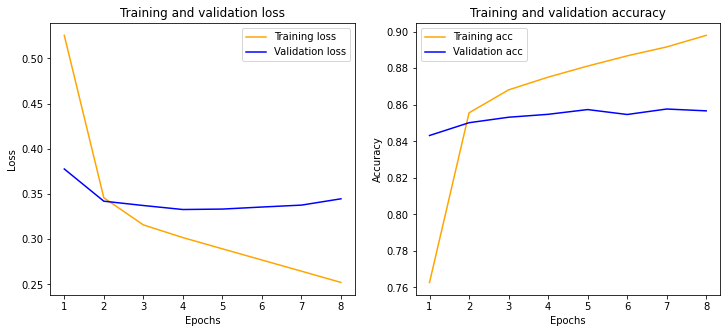

<IPython.core.display.Javascript object>

In [18]:
plot_history(history)

In [19]:
model = my_gmp(embed_layer)
history = train_m(model)
results = model.evaluate(x_test, y_test, verbose=2)
# print(results)
result_list.append([model, results[1]])

1537/1537 - 2s - loss: 0.3857 - accuracy: 0.8390


<IPython.core.display.Javascript object>

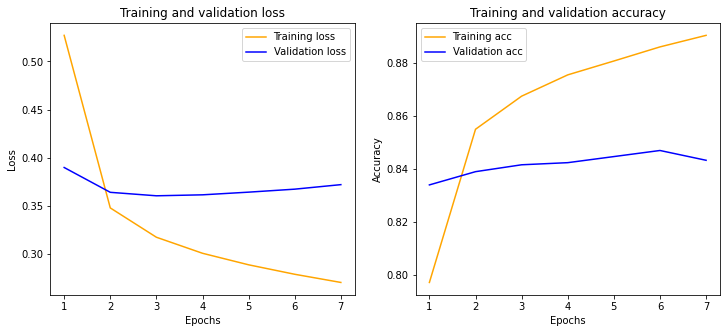

<IPython.core.display.Javascript object>

In [20]:
plot_history(history)

In [21]:
model = my_cnn(embed_layer)
history = train_m(model)
results = model.evaluate(x_test, y_test, verbose=2)
# print(results)
result_list.append([model, results[1]])

1537/1537 - 2s - loss: 0.3809 - accuracy: 0.8494


<IPython.core.display.Javascript object>

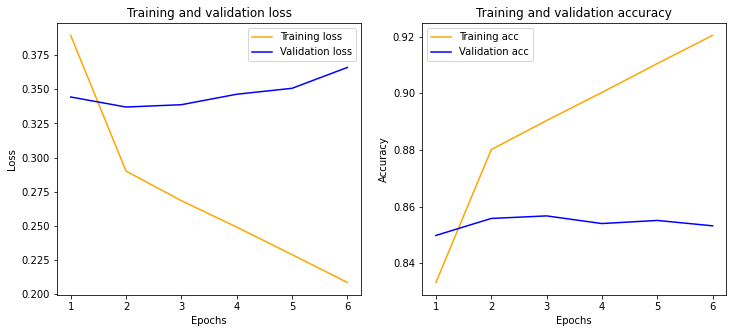

<IPython.core.display.Javascript object>

In [22]:
plot_history(history)

## 훈련 결과

| model | validation acc |
| --- | --- |
| LSTM | 85.00% |
| GMP | 83.90% |
| 1D-CNN | 84.94% |

3개의 모델의 훈련 결과는 위의 표와 같습니다.  
별도의 학습 파라미터가 존재하지 않는 Global Max Pooling가 포함되어 있는 모델의 경우도 다른 두 모델에 비해 정확도는 떨어지지만 좋은 결과가 나왔습니다.  
모든 모델들은 5 epoch 이전에 validation loss가 상승하는 과적합 양상을 보였고, 그에 따라 10 epoch 이전에 훈련이 종료되었습니다.

## 임베딩 레이어 성능 확인

훈련한 3개의 네트워크 중 validation accuracy가 가장 높은 모델의 임베딩 레이어의 가중치를 불러옵니다.

In [23]:
result_list.sort(key=lambda x: x[1])
model = result_list[0][0]
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


<IPython.core.display.Javascript object>

임베딩 레이어의 가중치를 파일 형태로 저장하고, 주어진 단어와 유사한 단어를 찾도록하여 어떠한 결과가 나오는지 확인합니다.

In [24]:
import os


word2vec_file_path = (
    os.getenv("HOME") + "/aiffel/sentiment_classification/data/word2vec.txt"
)
f = open(word2vec_file_path, "w")
f.write("{} {}\n".format(vocab_size - 4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write("{} {}\n".format(index_to_word[i], " ".join(map(str, list(vectors[i, :])))))
f.close()

<IPython.core.display.Javascript object>

In [25]:
from gensim.models.keyedvectors import Word2VecKeyedVectors


word_vectors = Word2VecKeyedVectors.load_word2vec_format(
    word2vec_file_path, binary=False
)
word_vectors.similar_by_word("나무")

[('참', 0.8432246446609497),
 ('믹', 0.8340432047843933),
 ('남주', 0.8175192475318909),
 ('3', 0.8152365684509277),
 ('김지영', 0.802465558052063),
 ('폭소', 0.7990982532501221),
 ('종합', 0.7951544523239136),
 ('이제껏', 0.7950364351272583),
 ('객관적으로', 0.7783843874931335),
 ('힘든', 0.7717720866203308)]

<IPython.core.display.Javascript object>

"나무"라는 단어와 유사한 단어를 찾도록 하면, 영화 감상평에 쓰일 확률이 낮아서인지 연관성을 찾기 힘든 단어들이 출력됩니다.

In [26]:
word_vectors.similar_by_word("사랑")

[('괜찮', 0.931977391242981),
 ('서편제', 0.9138933420181274),
 ('명작', 0.9084169268608093),
 ('대부', 0.9039289951324463),
 ('각종', 0.899904727935791),
 ('굿', 0.8883476853370667),
 ('좋', 0.8880492448806763),
 ('재밌', 0.8878347277641296),
 ('☆', 0.8809769749641418),
 ('최고', 0.8797017335891724)]

<IPython.core.display.Javascript object>

"사랑"이라는 단어에 대해서는 "재밌"이나 "최고"와 같이 긍정적인 의미를 나타내는 단어들이 출력됩니다.  
흥미로운 점은 별도로 한글 이외의 문자를 제거하거나 대체하는 전처리를 진행하지 않아 "☆"이라는 특수 문자가 포함되어 있는 사실입니다.  
일반적으로 긍정의 의미를 담고 있으니, 학습은 잘 되었다고 생각됩니다.

## Pre-trained word vector 적용
사전학습되지 않은 임베딩 레이어를 훈련한 결과를 확인하였으니, 사전학습된 임베딩 레이어를 사용하여 훈련하면 결과가 어떻게 나올지 확인합니다.  
다음의 [출처](https://github.com/Kyubyong/wordvectors)에서 pre-trained 된 워드 벡터를 다운로드하여 불러옵니다.

In [27]:
from gensim.models import Word2Vec


word2vec_path = os.getenv("HOME") + "/aiffel/sentiment_classification/data/ko.bin"
word2vec = Word2Vec.load(word2vec_path)
word2vec.wv.similar_by_word("나무")

[('소나무', 0.7991706132888794),
 ('대나무', 0.7613740563392639),
 ('버드나무', 0.7342588305473328),
 ('참나무', 0.7181689739227295),
 ('나뭇가지', 0.7110863924026489),
 ('갈대', 0.6910358667373657),
 ('바위', 0.6636906862258911),
 ('매화', 0.6627185344696045),
 ('느티나무', 0.6549824476242065),
 ('팽나무', 0.6547843217849731)]

<IPython.core.display.Javascript object>

사전 학습된 워드 벡터가 한국어 위키피디아 내용을 기반으로 해서인지, 사전적인 정의로 "나무"와 관련된 단어들이 출력됩니다.

In [28]:
word2vec.wv.similar_by_word("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

<IPython.core.display.Javascript object>

"사랑"이라는 단어에 대해서는 유사한 감정 또는 상황을 나타내는 단어들이 등장합니다.

In [29]:
word2vec.wv.__dict__.keys()

dict_keys(['vectors', 'vocab', 'vector_size', 'index2word', 'vectors_norm'])

<IPython.core.display.Javascript object>

사전 학습된 워드 벡터의 shape을 확인합니다.

In [30]:
print(word2vec.wv.vectors.shape)

(30185, 200)


<IPython.core.display.Javascript object>

vocabulary 중 10000개의 단어들을 사용하기 위해 임의의 값으로 채워진 배열을 생성하고 `word2vec`으로부터 값을 불러와 저장합니다.

In [31]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

<IPython.core.display.Javascript object>

사전 학습된 정보를 `Embedding` 레이어의 초기화에 사용합니다.

In [32]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

embed_layer_pre = tf.keras.layers.Embedding(
    vocab_size,
    word_vector_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=maxlen,
    trainable=True,
)

<IPython.core.display.Javascript object>

사전 학습된 정보를 이용하여 초기화한 `Embedding` 레이어를 3개의 모델에 적용하여 훈련을 진행하고 성능을 평가합니다.

In [33]:
model = my_lstm(embed_layer_pre)
history = train_m(model)
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3728 - accuracy: 0.8486
[0.3727807104587555, 0.8486278653144836]


<IPython.core.display.Javascript object>

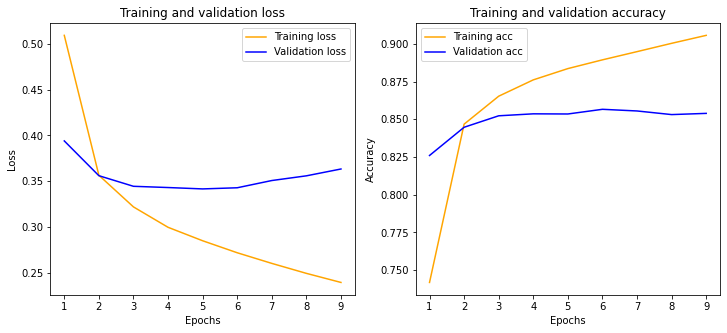

<IPython.core.display.Javascript object>

In [34]:
plot_history(history)

In [35]:
model = my_gmp(embed_layer_pre)
history = train_m(model)
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3983 - accuracy: 0.8280
[0.3983437418937683, 0.8280000686645508]


<IPython.core.display.Javascript object>

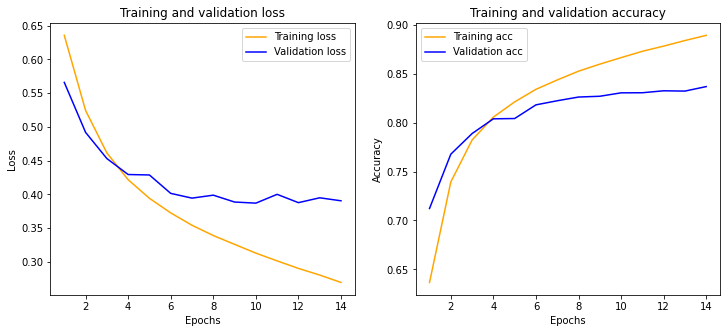

<IPython.core.display.Javascript object>

In [36]:
plot_history(history)

In [37]:
model = my_cnn(embed_layer_pre)
history = train_m(model)
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3979 - accuracy: 0.8454
[0.39793428778648376, 0.8454136848449707]


<IPython.core.display.Javascript object>

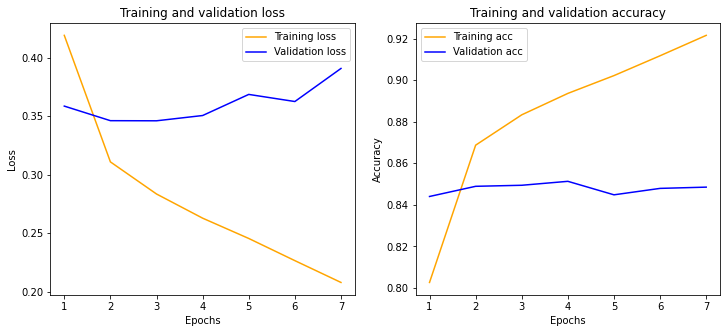

<IPython.core.display.Javascript object>

In [38]:
plot_history(history)

## 훈련 결과
| model | validation acc |
| --- | --- |
| LSTM | 84.86% |
| GMP | 82.80% |
| 1D-CNN | 84.54% |

사전 학습된 임베딩 정보를 적용한 3개의 모델의 훈련 결과는 위의 표와 같습니다. 사전 학습된 임베딩 정보를 적용하지 않은 모델들과 마찬가지로 GMP의 성능이 가장 낮습니다.

| model | validation acc | model (pre-trained) | validation acc |
| --- | --- | --- | --- |
| LSTM | 85.00% | LSTM | 84.86% |
| GMP | 83.90% | GMP | 82.80% |
| 1D-CNN | 84.94% | 1D-CNN | 84.54% |

사전 학습된 임베딩 정보를 적용하지 않은 모델들과 적용한 모델들의 훈련 결과는 위의 표와 같습니다. 소폭이긴 하지만 모든 모델들의 성능이 떨어졌습니다. 오차 범위라고 생각되지만 일반적으로 pre-trained 모델을 사용하여 fine-tuning을 진행하면 성능이 향상되는 경우가 많다는 점을 생각하면 고찰이 필요한 부분입니다.  
워드 벡터를 사용하여 주어진 단어와 유사한 단어를 찾은 결과를 바탕으로 생각하면, 단순히 단어의 사전적인 의미나 정의를 기반으로 긍정 또는 부정을 파악하기에는 상대적으로 불리하다는 결론입니다.  
사전 학습되지 않은 모델은 오히려 영화 감상평에 많이 사용되는 단어들에 대해서만 학습을 진행하였기에 어떤 것을 정의하거나 설명할 때에 많이 사용되는 단어들로 학습된 모델보다 유리하다고 생각됩니다.

## 결론
- 일반적으로 사전 학습된 정보를 사용하면 빠르게 수렴이 가능하거나, 성능이 향상되는 경우가 많지만 현재 실험에서 주어진 문제에 대해서는 성능에서 큰 차이를 보이지 못했습니다.
    - 사전 학습된 정보를 사용한 모델은 워드 벡터의 크기가 200으로 해당 정보를 사용하지 않은 모델의 16보다 훨씬 크지만 유사한 성능을 보였습니다.
- 예측하고자 하는 데이터(영화에 대한 짧은 리뷰)가 감정을 배제하고 객관적으로 서술되어야 하는 백과사전(사전 학습된 레이어가 사용한 데이터)과 성격이 달라 이러한 결과가 나온 것으로 생각됩니다.
- 따라서 사용하고자 하는 데이터와 해결하고자 하는 문제에 따라 사전 학습된 정보의 적용 여부를 고민해야 합니다.

## 루브릭
| 평가문항 | 상세기준 | 
| --- | --- |
| 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. | 3가지 이상의 모델이 성공적으로 시도됨 |
| 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. | gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함 |
| 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. | 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

### 루브릭 자체평가
1. LSTM을 사용한 모델, GlobalMaxPooilng을 적용한 모델, 1D Convolution을 사용한 모델, 총 3개의 모델을 사용하여 실험을 진행함
2. 직접 훈련한 모델의 임베딩 레이어와 사전 학습된 임베딩 레이어의 유사 단어 찾기 결과를 비교함
3. 감성분석 정확도는 검증 데이터를 기준으로 85%를 달성하였으나, 한국어 Word2Vec을 활용하여 달성하지 않음